<a href="https://colab.research.google.com/github/77class/car-license/blob/main/%EF%BC%AD11316018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#連 結 Google 雲端硬碟
from google.colab import drive

drive.mount('/content/gdriver')

Mounted at /content/gdriver


In [2]:
# 切換資料夾
%cd /content/gdriver/MyDrive/

/content/gdriver/MyDrive


In [3]:
!pip install easyocr
!pip install imutils
!pip install pytesseract
!pip install --upgrade sympy
!sudo apt install tesseract-ocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 41.9 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu121 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.13.3 which is incompatible.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete正在處理: car_license2/car-test.png


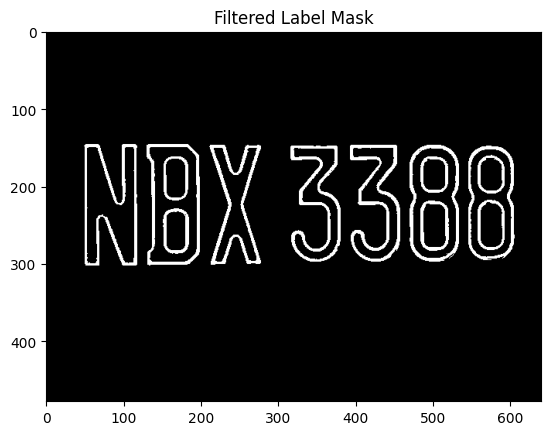

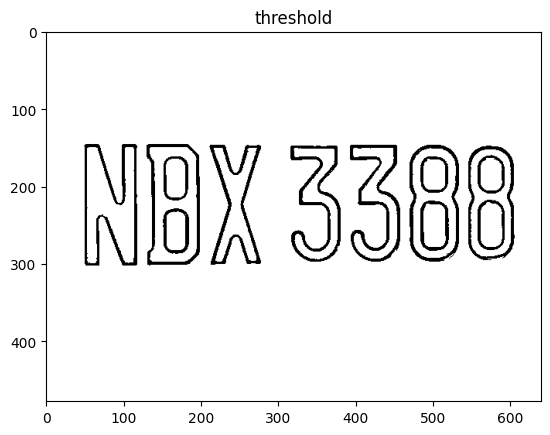

辨識結果:


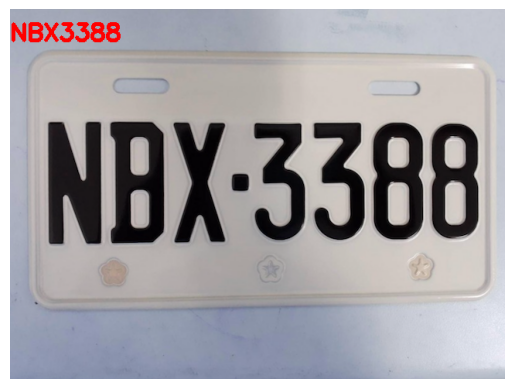

正在處理: car_license2/Cars80.png


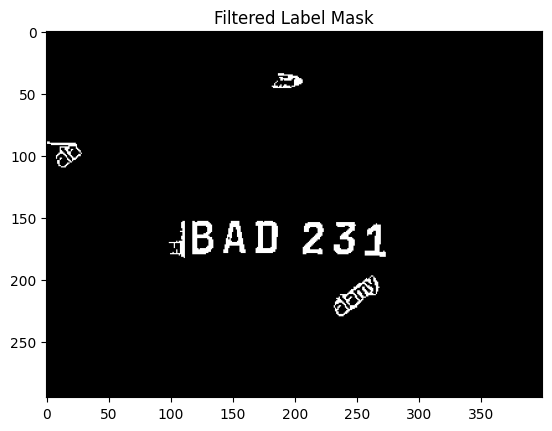

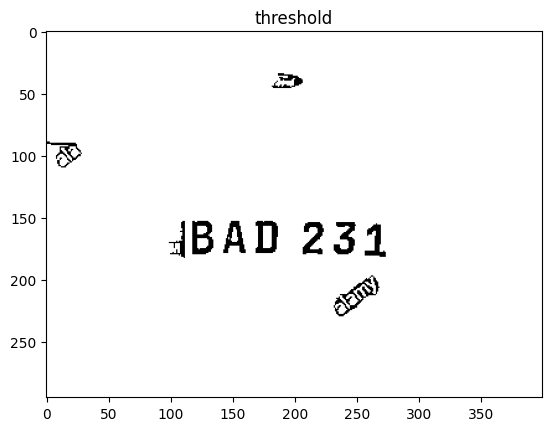

辨識結果:


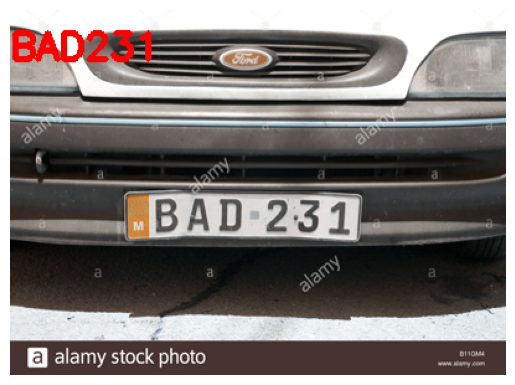

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import easyocr
import glob
import pytesseract
import re
from skimage import measure
import PIL
from PIL import Image

# 初始化 OCR 讀取器
reader = easyocr.Reader(['en'])

def dynamic_threshold(image):

    ## 根據圖像大小適應面積範圍

    image_area = image.shape[0] * image.shape[1]
    lower_bound = image_area * 0.001  # 最小像素數佔總區域比例
    upper_bound = image_area * 0.1    # 最大像素數佔總區域比例
    return lower_bound, upper_bound

def filter_labels(thresh, lower, upper):

    ## 去除小區域並保留可能的數字區域

    labels = measure.label(thresh, background=0)
    mask = np.zeros(thresh.shape, dtype="uint8")

    for label in np.unique(labels):
        if label == 0:  # 背景忽略
            continue
        label_mask = np.zeros(thresh.shape, dtype="uint8")
        label_mask[labels == label] = 255
        num_pixels = cv2.countNonZero(label_mask)

        # 過濾極小的區域
        if lower < num_pixels < upper:
            # 使用 bounding box 判斷區域形狀
            x, y, w, h = cv2.boundingRect(label_mask)
            aspect_ratio = w / float(h)

            # 過濾過長或過窄的區域，保留合理寬高比
            if 0.2 < aspect_ratio < 2.5 and h > 10:
                mask = cv2.add(mask, label_mask)
    return mask

def preprocess_image(file_path):

    ## 讀取並預處理圖片

    img = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 高斯模糊處理與邊緣檢測
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 50, 150)

    return img, gray, edged

def recognize_plate(image):

    ## 使用 EasyOCR 辨識車牌文字

    _,bg = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
    ## 灰階影像,像素值低於 127 的部分為白色，高於或等於 127 的部分為黑色
    plt.imshow(bg, cmap="gray")
    plt.title("threshold")
    plt.show()

    result = reader.readtext(bg)
    return result

def process_images(folder_path):

    ## 處理所有圖片

    png = glob.glob(f"{folder_path}/*.png")
    jpg = glob.glob(f"{folder_path}/*.jpg")
    jpeg = glob.glob(f"{folder_path}/*.jpeg")
    files = png + jpg +jpeg
    for file in files:
        print(f"正在處理: {file}")
        img, gray, edged = preprocess_image(file)

        # 自適應閾值和二值化,所有符合條件的像素將被設定為255（白色）
        plate_region = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 10)

        # 動態過濾 Label
        # 去除背景區域，保留前景目標,突出顯示目標區域
        lower, upper = dynamic_threshold(plate_region)
        filtered_mask = filter_labels(plate_region, lower, upper)

        plt.imshow(filtered_mask, cmap="gray")
        plt.title("Filtered Label Mask")
        plt.show()

        # OCR(光學字元辨識) 車牌辨識
        result = recognize_plate(filtered_mask)
        if result:
            print("辨識結果:")
            # 去除非英文字母或數字
            # 修正錯誤辨識的字元,"|","/"
            # 去除空格,轉換為大寫字母
            text = re.sub('[^A-Za-z0-9]', '',result[0][1].replace("|", "1").replace("/", "1").replace(' ', '')).upper()

            font = cv2.FONT_HERSHEY_SIMPLEX
            text_x = 0
            text_y = 40
            # 影像 左上角（0, 40）上疊加辨識結果
            # 定義辨識結果的字體＆大小＆顏色
            res = cv2.putText(img, text = text, org = (text_x, text_y), fontFace = font, fontScale = 1, color = (0, 0, 255), thickness = 3)

            plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
            # 隱藏座標軸
            plt.axis('off')
            plt.show()

        else:
            print("無法辨識文字！")

# 執行批量處理
process_images("car_license2")
